# Spatial biases

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import math
import os

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from tools import (
    check_equal_period,
    create_cordex_grid,
    fix_360_longitudes,
    load_obs,
    mask_invalid,
    open_datasets,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    variable_mapping,
)

dask.config.set(scheduler="single-threaded")

In [3]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:43157' processes=16 threads=16, memory=125.79 GiB>

In [5]:
variable = "pr"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period = slice("1989", "2008")

In [6]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [7]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [8]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## CERRA and ERA5

In [9]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    ds = load_obs(variable, dset)
    ds = ds.sel(time=period).compute()
    ds = fix_360_longitudes(ds, lonname="longitude")
    if not variable_mapping[dset][variable] == variable:
        ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
    ds = standardize_unit(ds, variable)
    dsets[dset] = ds

Convert precipitation from meters to millimeters (mm).


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 18.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [10]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [11]:
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=False)
    dsets[dset] = regridder(ds)

In [12]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

# CMIP6

In [13]:
mip_era = "CMIP6"
driving_source_id = "ERA5"

In [15]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'RegCM5-0'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp370.r3i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.CNRM-ESM2-1.historical.r1i1p1f2.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-METNo.NorESM2-MM.ssp370.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.MIROC6.historical.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.historical.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.MIROC6.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-

/home/lbuntemeyer/python/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(

Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
merging CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216 with CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.fx.v20241216
merging CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1

In [16]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.mon.v20250201 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.ev

In [17]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).


In [20]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       b

In [21]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site

In [22]:
seasonal_bias.to_netcdf(f"{save_results_path}/{variable}_{mip_era}_spatial_bias.nc")

# CMIP5

In [23]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"
# Define how to merge the files in xarray

In [24]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALADIN53', 'ALADIN63', 'ALARO-0', 'CCLM4-8-17', 'COSMO-crCLIM-v1-1', 'HadREM3-GA7-05', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-2'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813
Warning for CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.

In [25]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140218 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 does not match with slice('1989', '2008', None)
Tem

In [26]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert pr

In [27]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_551x551_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (551, 551) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_485x485_4

In [28]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.78 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [29]:
seasonal_bias.to_netcdf(f"{save_results_path}/{variable}_{mip_era}_spatial_bias.nc")

# Plot

In [30]:
CMIP6_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP6_spatial_bias.nc"
)
CMIP5_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP5_spatial_bias.nc"
)

In [31]:
import pandas as pd

eur_colors = pd.read_csv("eurocordex_models.csv")

In [32]:
projects = ["CMIP5", "CMIP6"]
models_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"]["model"].values
parents_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"]["parent"].values
parents_cmip6[
    eur_colors[eur_colors["mip_era"] == "CMIP6"]["parent_mip_era"] == "CMIP6"
] = np.nan

In [33]:
models = []
for m5, m6 in zip(parents_cmip6, models_cmip6):
    models.append(f"cmip5_{m5}")
    models.append(f"cmip6_{m6}")

In [34]:
models = [m for m in models if "_nan" not in m]

In [35]:
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [36]:
models = obs_seasonal_bias.dset_id.values.tolist() + models

/tmp/ipykernel_3146960/2787641098.py:3: FutureWarning: This is a FutureWarning example
  warnings.warn("This is a FutureWarning example", FutureWarning)
/tmp/ipykernel_3146960/2787641098.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_3146960/2787641098.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_3146960/2787641098.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_3146960/2787641098.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)


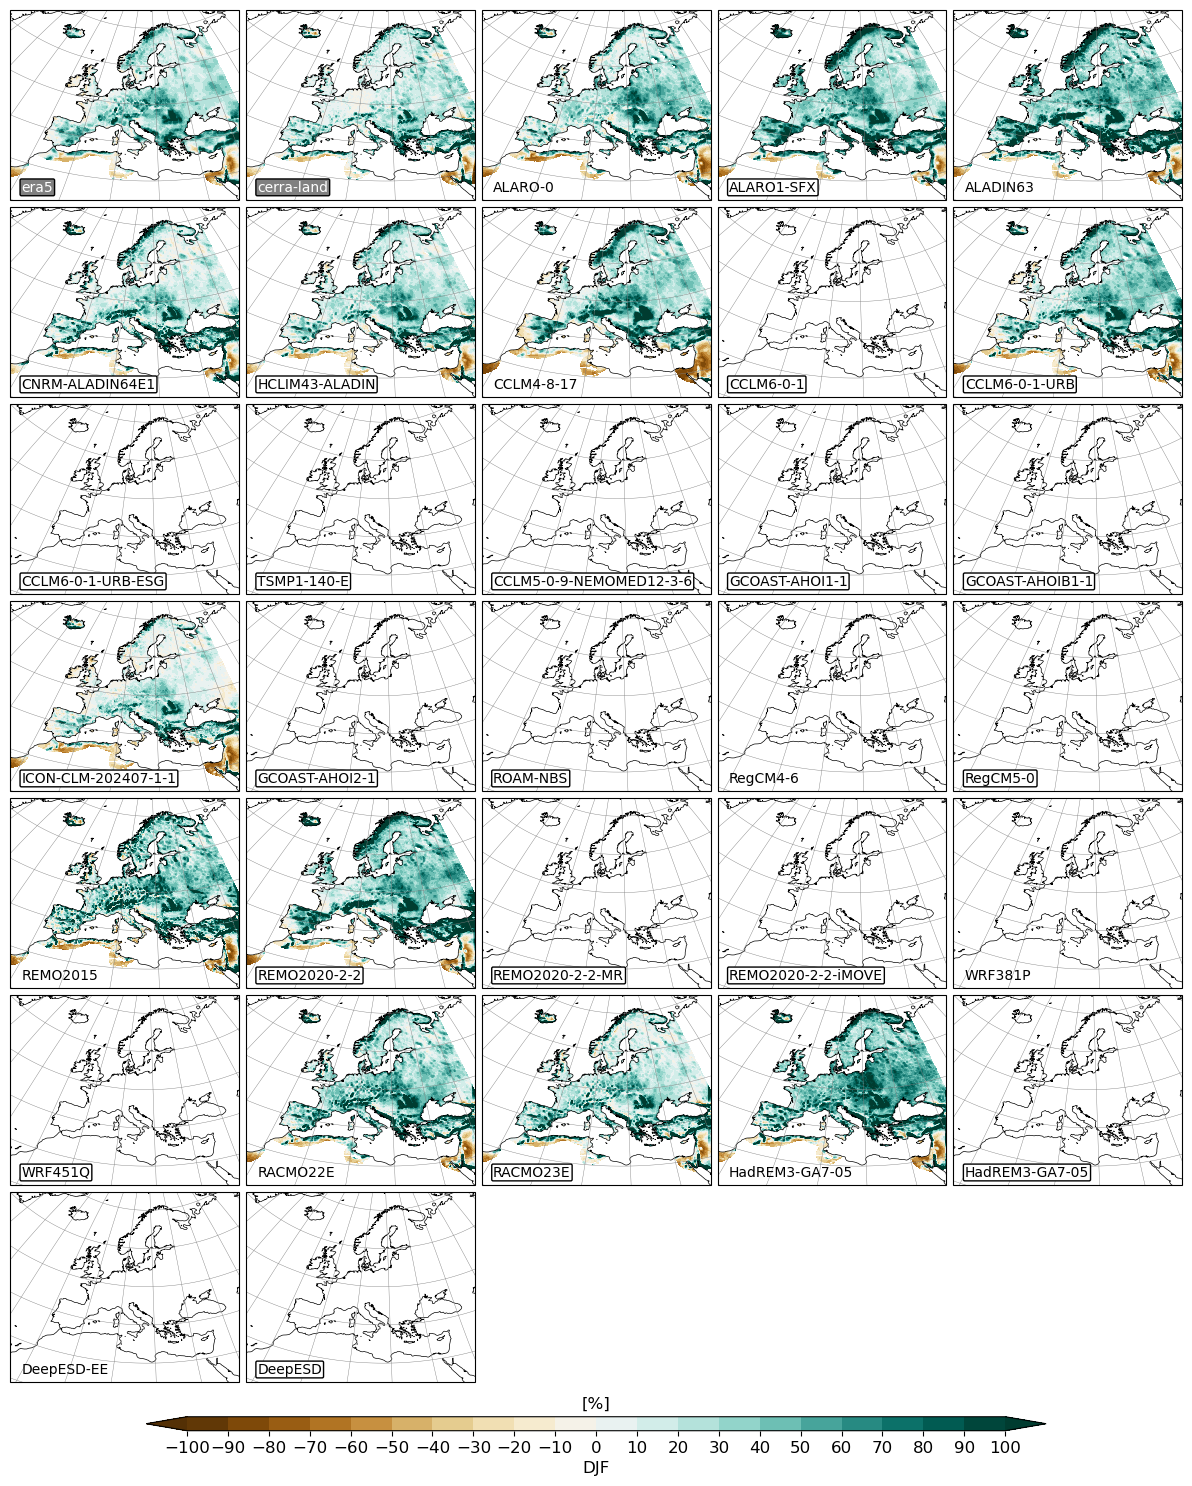

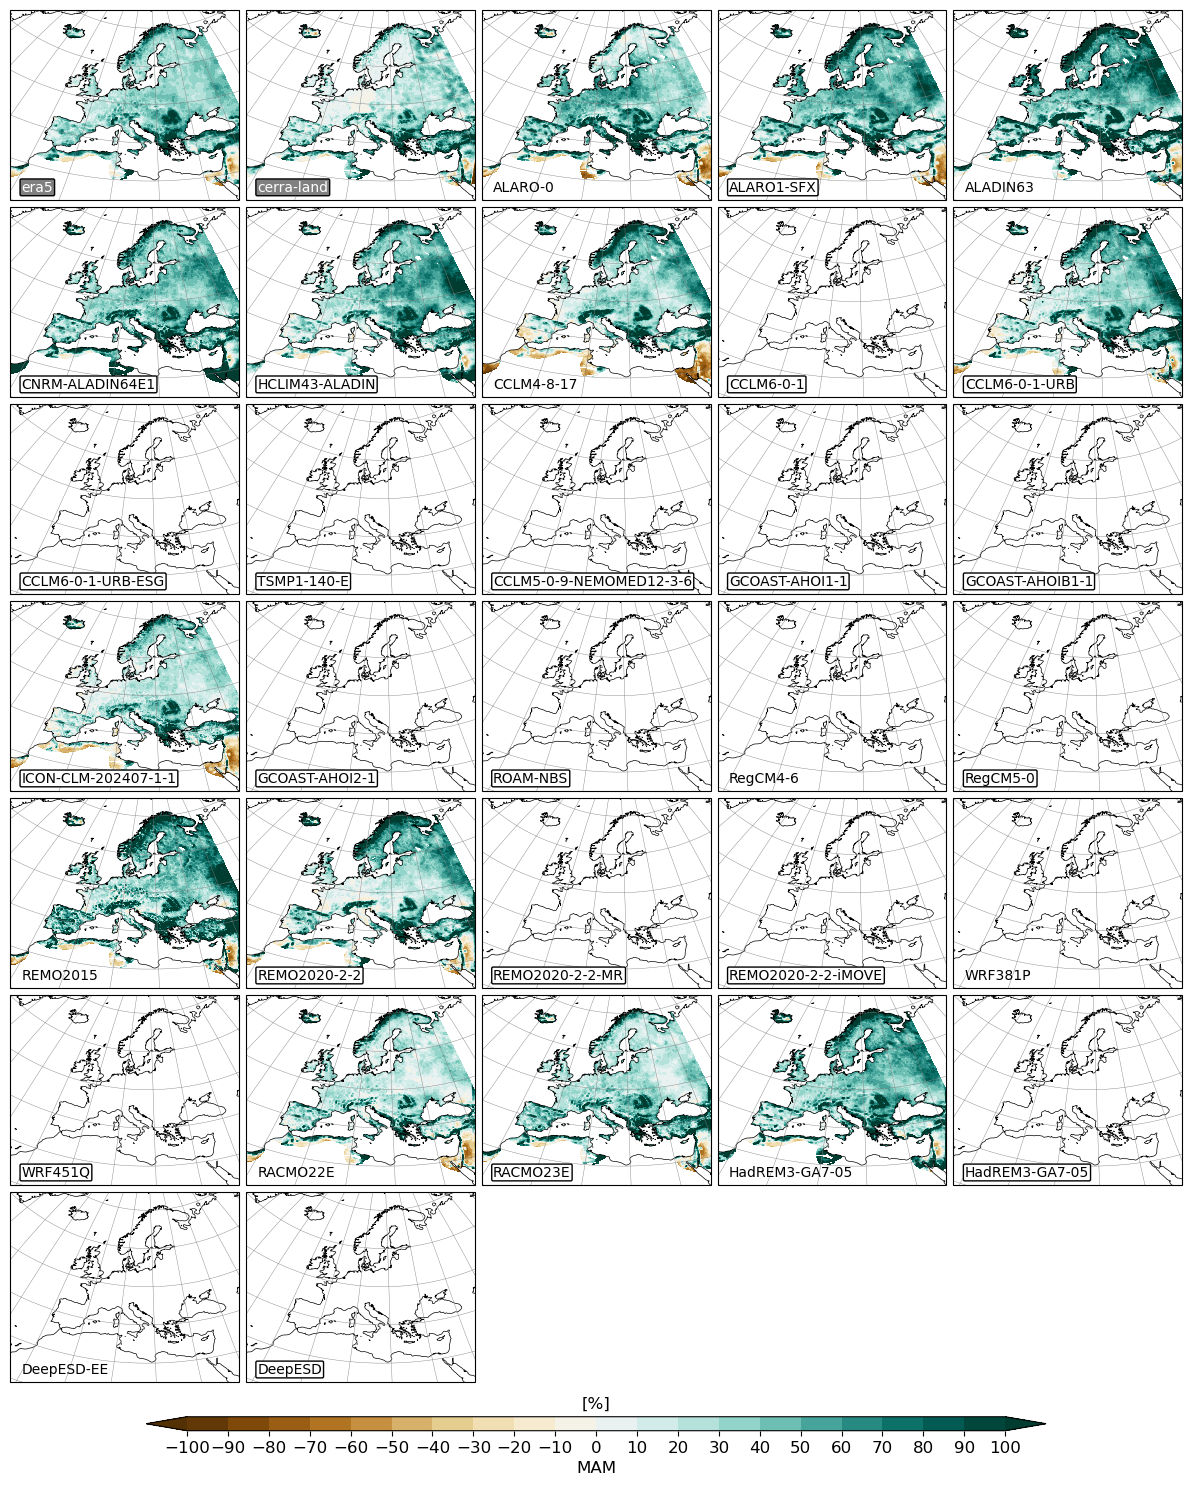

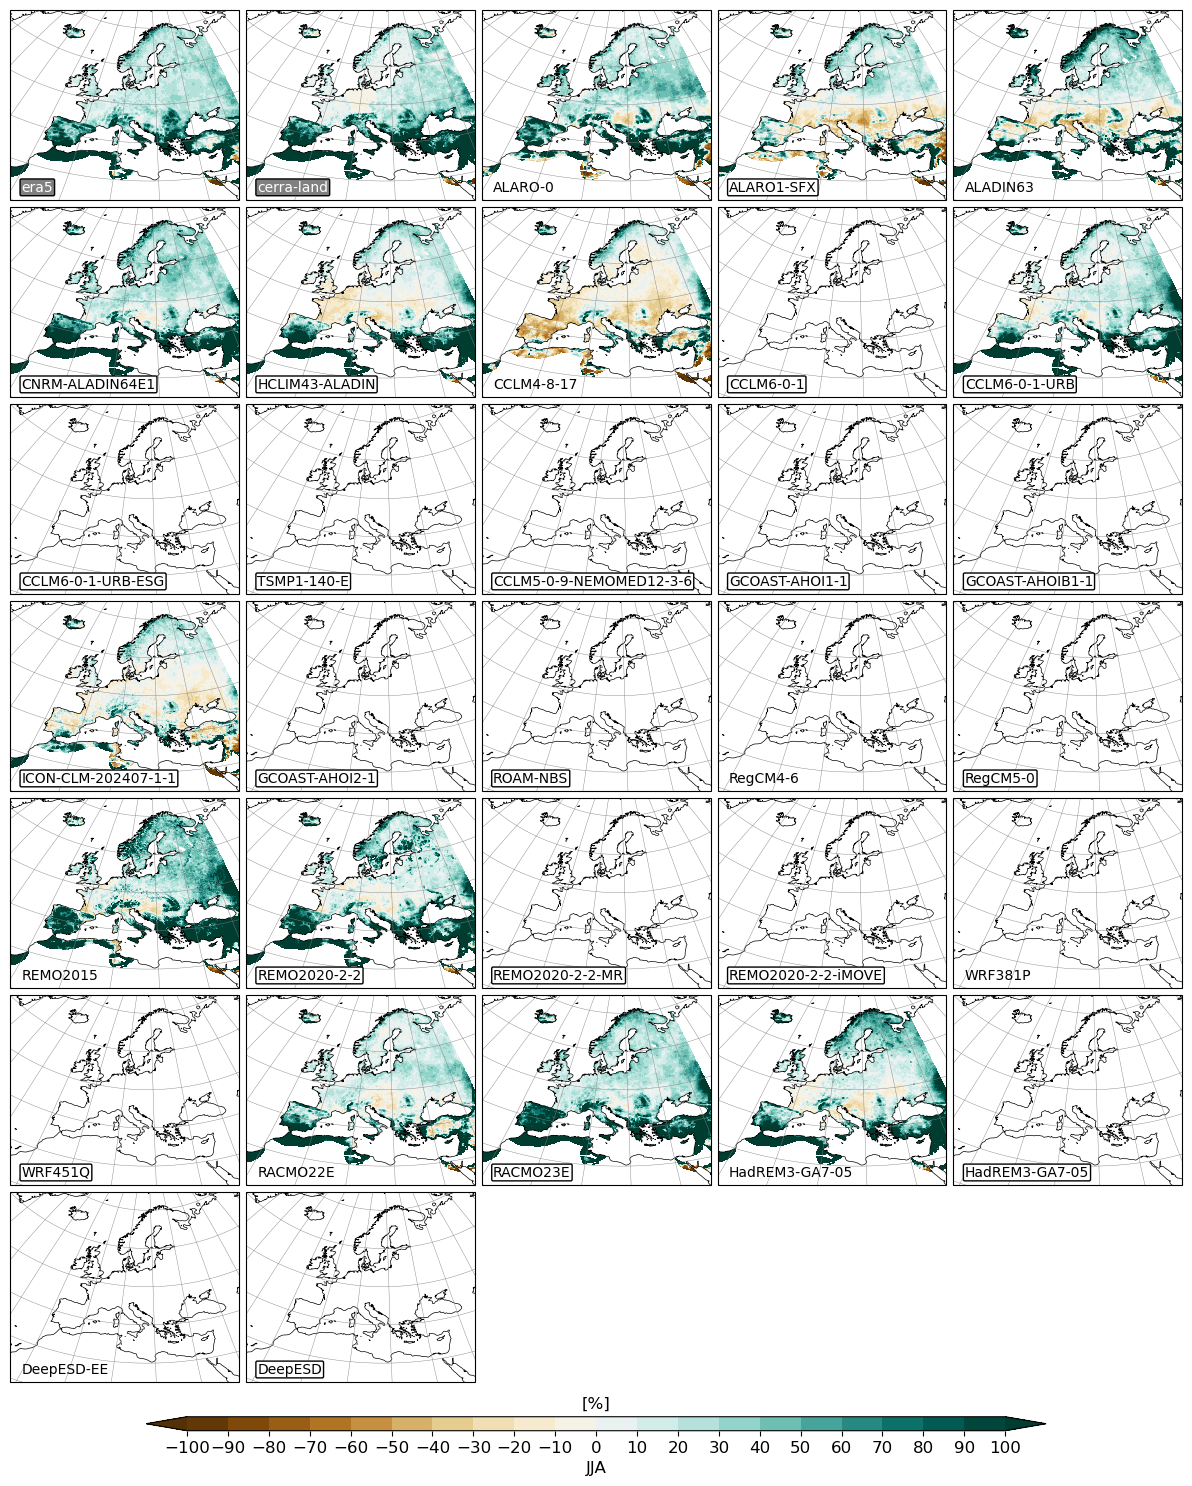

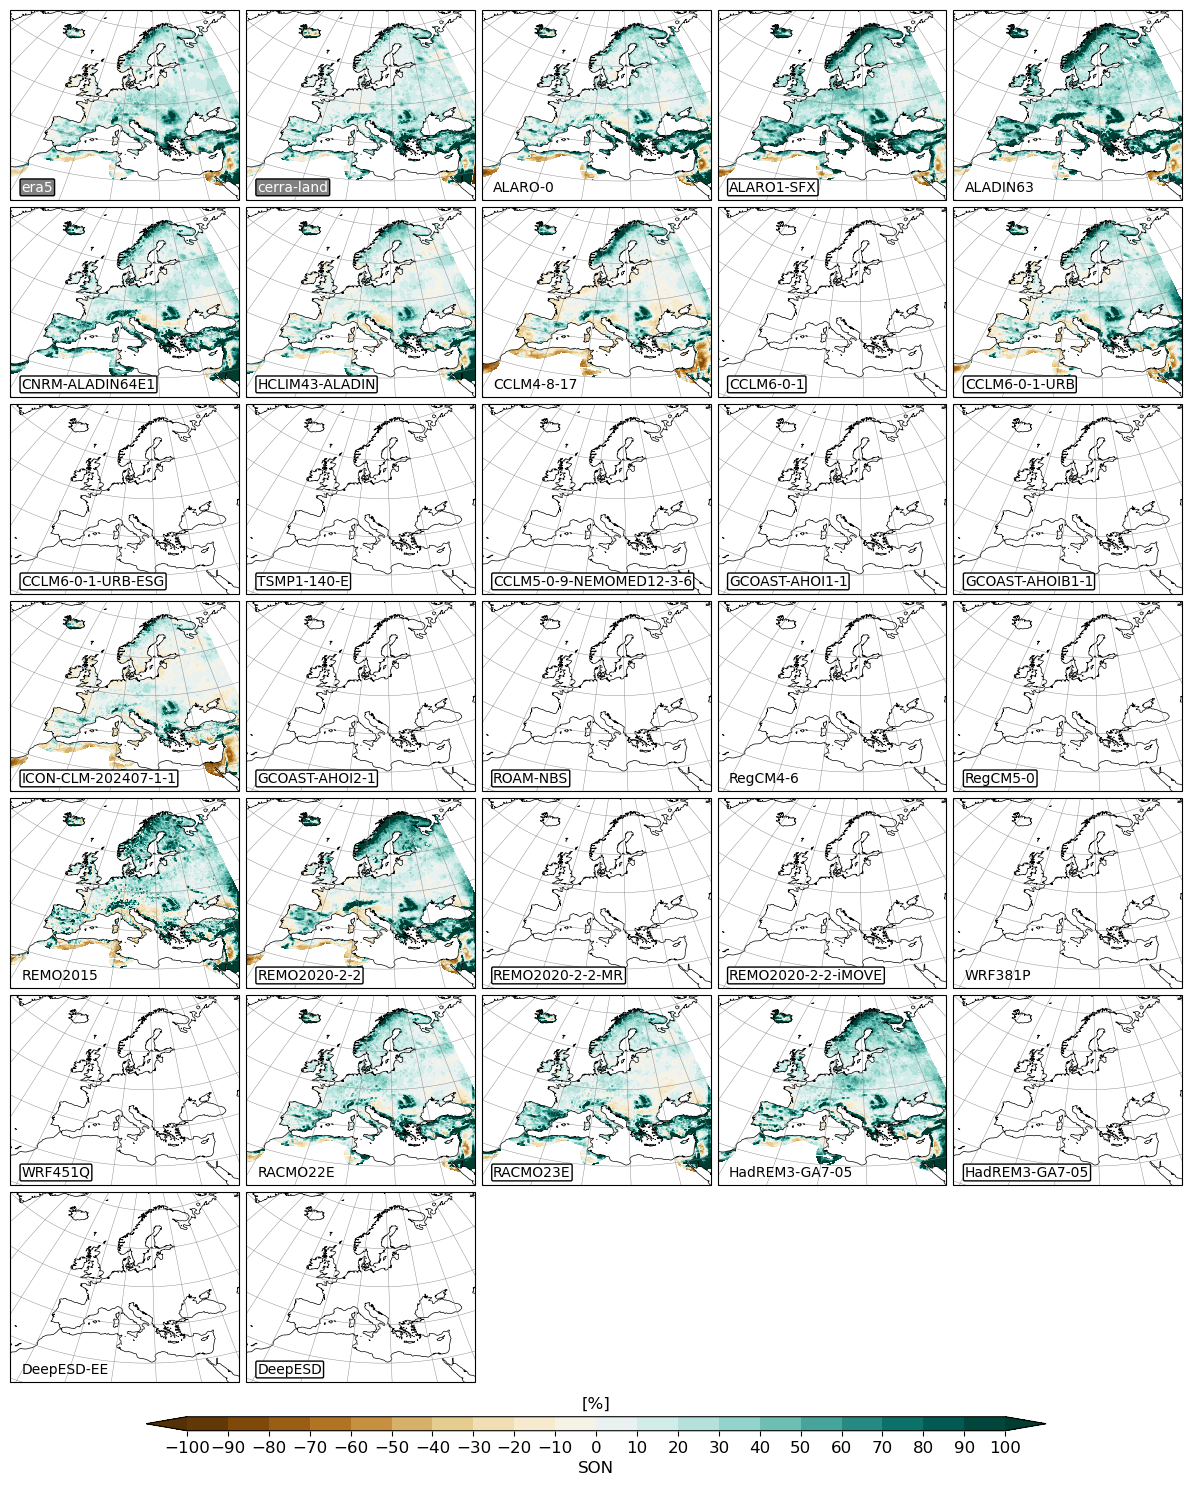

In [37]:
import warnings

warnings.warn("This is a FutureWarning example", FutureWarning)

for season in ["DJF", "MAM", "JJA", "SON"]:

    ncols = 5
    nrows = math.ceil(len(models) / ncols)
    transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
    projection = transform

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(12, 14),
    )

    axs = axs.flatten()

    for n_m, model in enumerate(models):

        if "cmip5" in model:
            ds = CMIP5_seasonal_bias
            project = "cmip5"
            model = model.split(project + "_")[1]
        elif "cmip6" in model:
            ds = CMIP6_seasonal_bias
            project = "cmip6"
            model = model.split(project + "_")[1]
        else:
            ds = obs_seasonal_bias
            project = "obs"

        aspect = ds.cf.sizes["Y"] / ds.cf.sizes["X"]

        if project == "obs":
            data = (
                ds[variable]
                .isel(
                    season=np.where(ds.season == season)[0],
                    dset_id=np.where(ds.dset_id == model)[0],
                )
                .squeeze(dim=["season", "dset_id"])
            )

        elif model in ds.dset_id:
            data = (
                ds[variable]
                .isel(
                    season=np.where(ds.season == season)[0],
                    dset_id=np.where(ds.dset_id == model)[0],
                )
                .squeeze(dim=["season", "dset_id"])
            )
        else:
            data = (
                ds[variable]
                .isel(season=np.where(ds.season == season)[0], dset_id=0)
                .squeeze(dim=["season"])
                * np.nan
            )

        cs = axs[n_m].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            levels=var_dic[variable]["levels"],
            extend="both",
            cmap=var_dic[variable]["cmap"],
        )

        axs[n_m].set_aspect(round(aspect, 3))
        axs[n_m].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[n_m].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[n_m].xaxis.set_major_formatter(lon_formatter)
        axs[n_m].yaxis.set_major_formatter(lat_formatter)

        if project == "cmip6":
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                bbox=dict(
                    facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )
        elif project == "cmip5":
            axs[n_m].set_title(model, loc="left", y=0, x=0.05, fontsize=10)
        elif project == "obs":
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                color="white",
                bbox=dict(
                    facecolor="grey", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )

    cbar_ax = fig.add_axes([0.125, -0.025, 0.75, 0.01])
    cbar = fig.colorbar(
        cs, cax=cbar_ax, orientation="horizontal", ticks=var_dic[variable]["levels"]
    )
    cbar_ax.set_title(f"[{var_dic[variable]['units']}]", fontsize=12)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(season, fontsize=12)

    for ax in axs[len(models) :]:
        ax.remove()

    for ax in axs:
        ax.set_aspect("auto")

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

    plt.savefig(
        f"{save_figure_path}/CMIP6-parents_eobs_{variable}_{season}_{period.start}-{period.stop}.png",
        bbox_inches="tight",
    )